
Running example of classification using RandomForest

Test Error = 0.0416666666667
Learned classification forest model:
TreeEnsembleModel classifier with 3 trees

  Tree 0:
    If (feature 468 <= 0.0)
     If (feature 378 <= 0.0)
      If (feature 623 <= 0.0)
       Predict: 0.0
      Else (feature 623 > 0.0)
       Predict: 1.0
     Else (feature 378 > 0.0)
      Predict: 1.0
    Else (feature 468 > 0.0)
     Predict: 0.0
  Tree 1:
    If (feature 406 <= 72.0)
     If (feature 546 <= 253.0)
      Predict: 0.0
     Else (feature 546 > 253.0)
      Predict: 1.0
    Else (feature 406 > 72.0)
     Predict: 1.0
  Tree 2:
    If (feature 578 <= 0.0)
     If (feature 661 <= 126.0)
      If (feature 358 <= 0.0)
       Predict: 1.0
      Else (feature 358 > 0.0)
       Predict: 0.0
     Else (feature 661 > 126.0)
      Predict: 0.0
    Else (feature 578 > 0.0)
     If (feature 544 <= 227.0)
      Predict: 0.0
     Else (feature 544 > 227.0)
      Predict: 1.0


Running example of regression u

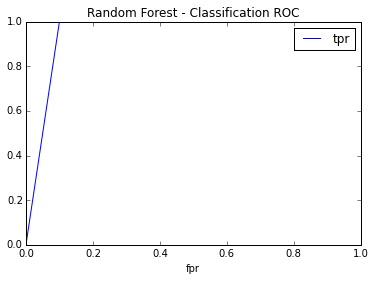

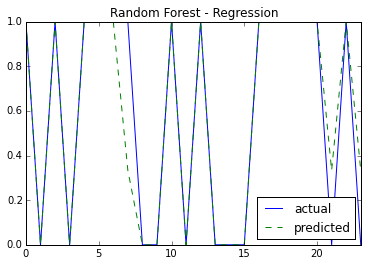

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from __future__ import print_function


import sys


import pandas
from pyspark.context import SparkContext

from pyspark.sql import SQLContext


from pyspark.mllib.tree import RandomForest

from pyspark.mllib.util import MLUtils
from sklearn import metrics







def testClassification(trainingData, testData):
    
	# Train a RandomForest model.
    
	#  Empty categoricalFeaturesInfo indicates all features are continuous.
    
	#  Note: Use larger numTrees in practice.
    
	#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
    
	model = RandomForest.trainClassifier(trainingData, numClasses=2,categoricalFeaturesInfo={},numTrees=3, featureSubsetStrategy="auto",impurity='gini', maxDepth=4, maxBins=32)



	# Evaluate model on test instances and compute test error
    
	predictions = model.predict(testData.map(lambda x: x.features))

	labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)

	predictedDataFrame = sqlContext.createDataFrame(labelsAndPredictions)
	

	# Creates data frame to plot ROC curve
	fpr, tpr, _ = metrics.roc_curve(predictedDataFrame.toPandas()['_1'].values, predictedDataFrame.toPandas()['_2'].values)
	
	
	df = pandas.DataFrame(dict(fpr=fpr, tpr=tpr))
	

	# ROC curve plot
	df.plot('fpr', 'tpr', title = 'Random Forest - Classification ROC')
	testErr = labelsAndPredictions.filter(lambda v_p: v_p[0] != v_p[1]).count()/float(testData.count())

	print('Test Error = ' + str(testErr))

	print('Learned classification forest model:')

	print(model.toDebugString())




def testRegression(trainingData, testData):
    
	# Train a RandomForest model.
    
	#  Empty categoricalFeaturesInfo indicates all features are continuous.
    
	#  Note: Use larger numTrees in practice.
    
	#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
    
	model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},numTrees=3, featureSubsetStrategy="auto",impurity='variance', maxDepth=4, maxBins=32)



	# Evaluate model on test instances and compute test error
    
	predictions = model.predict(testData.map(lambda x: x.features))

	labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)

	predictedDataFrame = sqlContext.createDataFrame(labelsAndPredictions)	
	# Created data frame for visualization
	df = predictedDataFrame.toPandas()
	df.columns = ['actual', 'predicted']	
	# 'Line' plot is used here to differentiate 'actual' and 'predicted' values
	df.plot(style=['-','--'], title = 'Random Forest - Regression')
	testMSE = labelsAndPredictions.map(lambda v_p1: (v_p1[0] - v_p1[1]) * (v_p1[0] - v_p1[1])).sum() / float(testData.count())

	print('Test Mean Squared Error = ' + str(testMSE))

	print('Learned regression forest model:')

	print(model.toDebugString())


# Load and parse the data file into an RDD of LabeledPoint.
    
data = MLUtils.loadLibSVMFile(sc, '/Data/Spark/MLLib/Sample_LibSVM_Data.txt')

# Split the data into training and test sets (30% held out for testing)
    
(trainingData, testData) = data.randomSplit([0.7, 0.3])

    

print('\nRunning example of classification using RandomForest\n')
    
testClassification(trainingData, testData)

    

print('\nRunning example of regression using RandomForest\n')
    
testRegression(trainingData, testData)

    
